In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller Aumentado para estacionariedad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import STL

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb
pd.options.display.float_format = '{:.9f}'.format
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)


In [2]:
df = pd.read_csv('.\data\Microsoft_Stock.csv')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\javie\AppData\Local\Temp\ipykernel_21652\738542129.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('.\data\Microsoft_Stock.csv')


,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'], inplace =True)

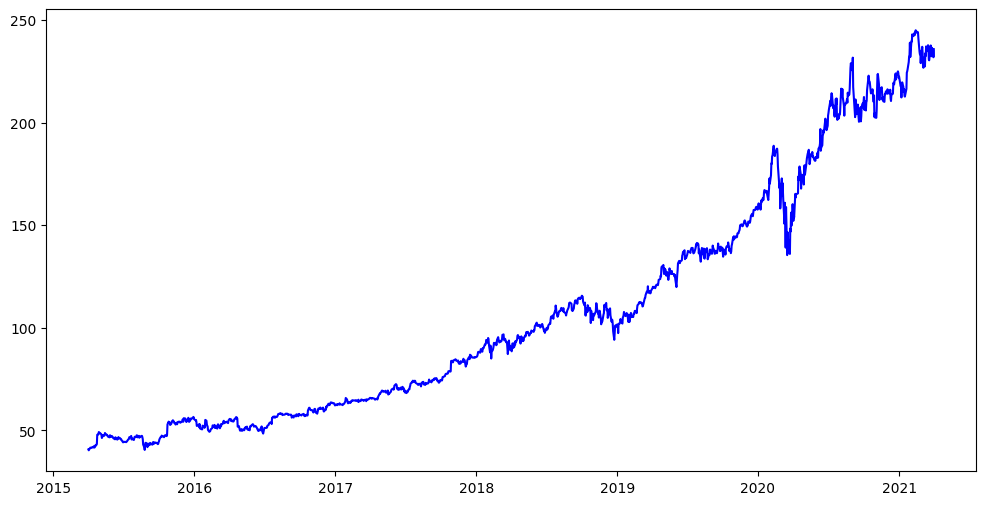

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], color = 'blue')
plt.show()

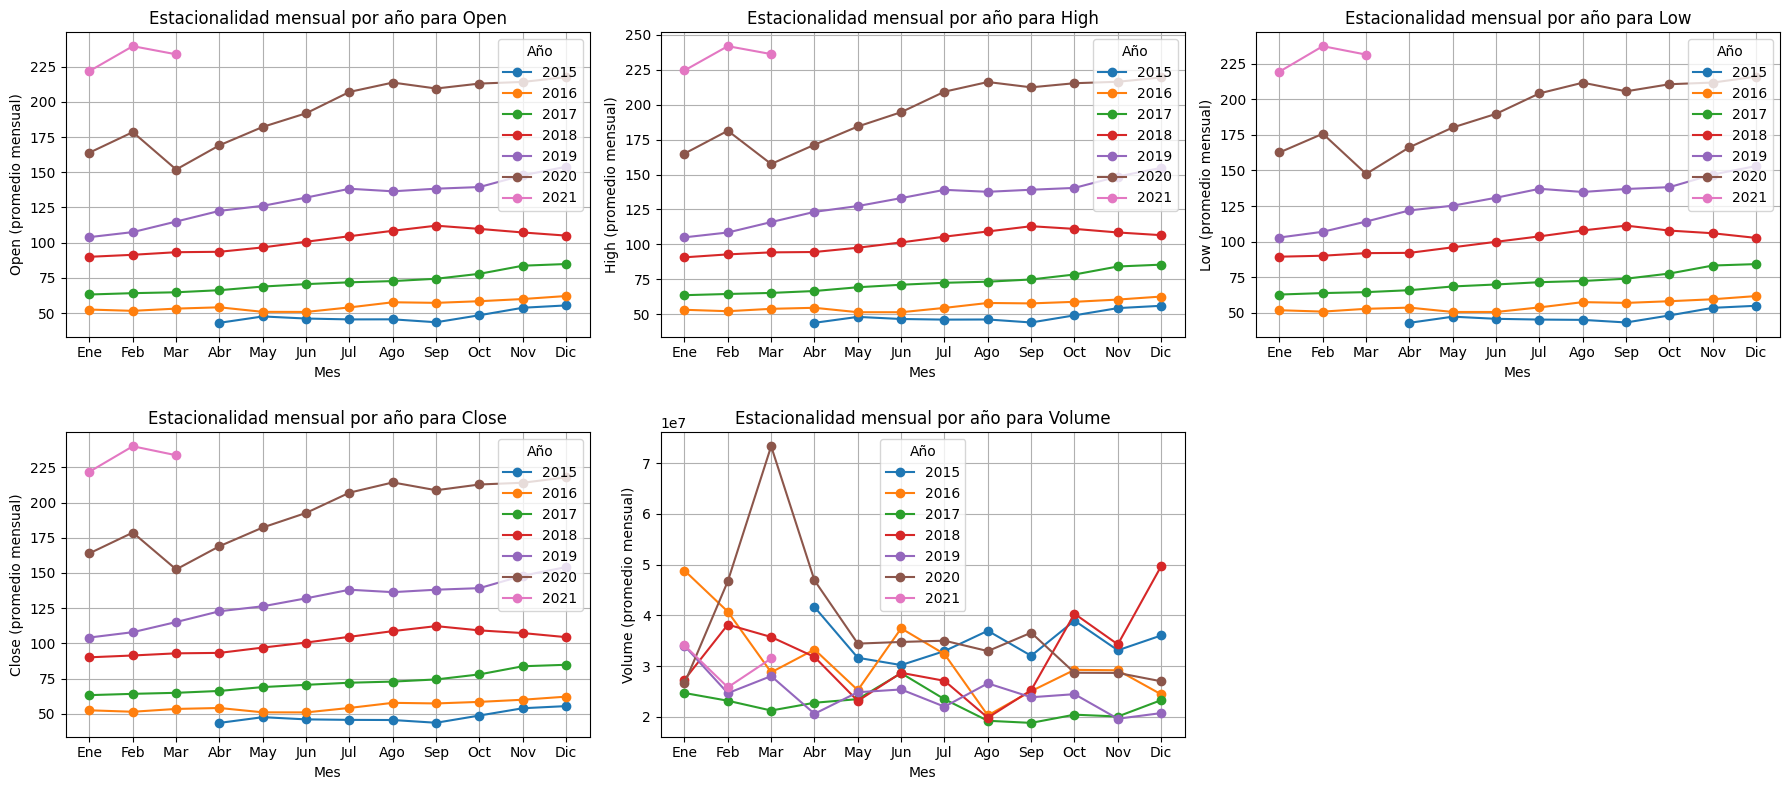

In [6]:
def seasonal_plot_by_year(df, col, ax=None):
    df = df.copy()
    df['Year'] = df.index.year
    df['Month'] = df.index.month

    # Agrupar por año y mes, calcular el promedio
    grouped = df.groupby(['Year', 'Month'])[col].mean().unstack(level=0)

    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Dibujar una línea por año
    for year in grouped.columns:
        ax.plot(grouped.index, grouped[year], marker='o', label=str(year))

    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    ax.set_xlabel('Mes')
    ax.set_ylabel(f'{col} (promedio mensual)')
    ax.set_title(f'Estacionalidad mensual por año para {col}')
    ax.legend(title='Año')
    ax.grid(True)


# --- Ejemplo de uso para varias columnas con subplots ---
cols = [col for col in df.columns if col != 'Date']
n = len(cols)
plots_per_row = 3
rows = int(np.ceil(n / plots_per_row))

fig, axs = plt.subplots(rows, plots_per_row, figsize=(6 * plots_per_row, 4 * rows))
axs = np.atleast_2d(axs)

for i, col in enumerate(cols):
    r = i // plots_per_row
    c = i % plots_per_row
    seasonal_plot_by_year(df, col, ax=axs[r, c])

# Eliminar ejes vacíos
for j in range(n, rows * plots_per_row):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [8]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Month_name'] = df['Date'].dt.strftime('%b')
df['Quarter'] = df['Date'].dt.quarter

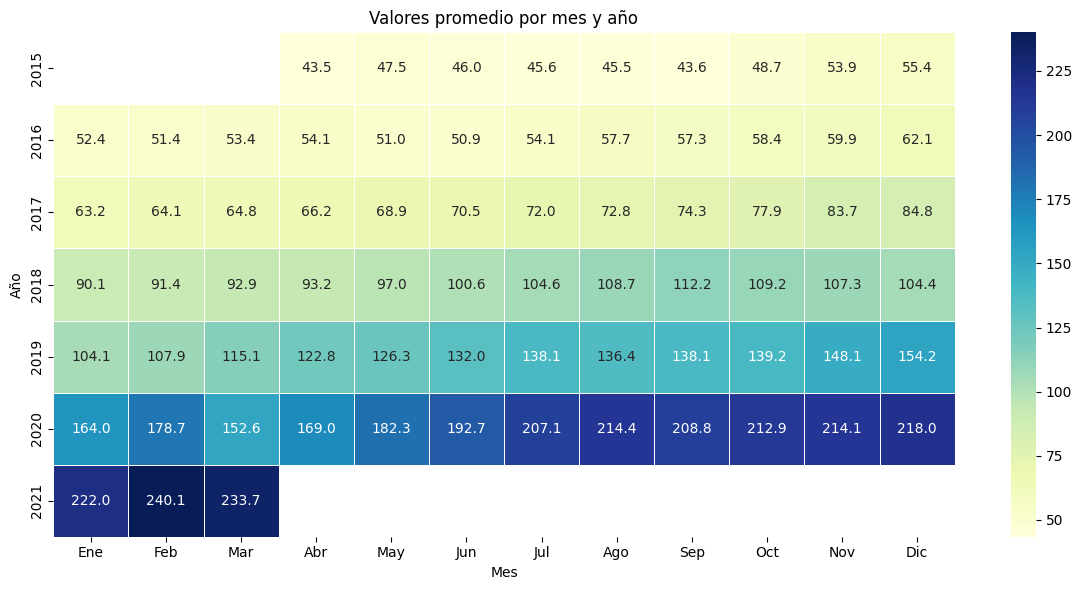

In [9]:
pivot_data = df.groupby(['Year', 'Month'])['Close'].mean().reset_index()
heatmap_data = pivot_data.pivot(index='Year', columns='Month', values='Close')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5,
            xticklabels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                         'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.title("Valores promedio por mes y año")
plt.xlabel("Mes")
plt.ylabel("Año")
plt.tight_layout()
plt.show()

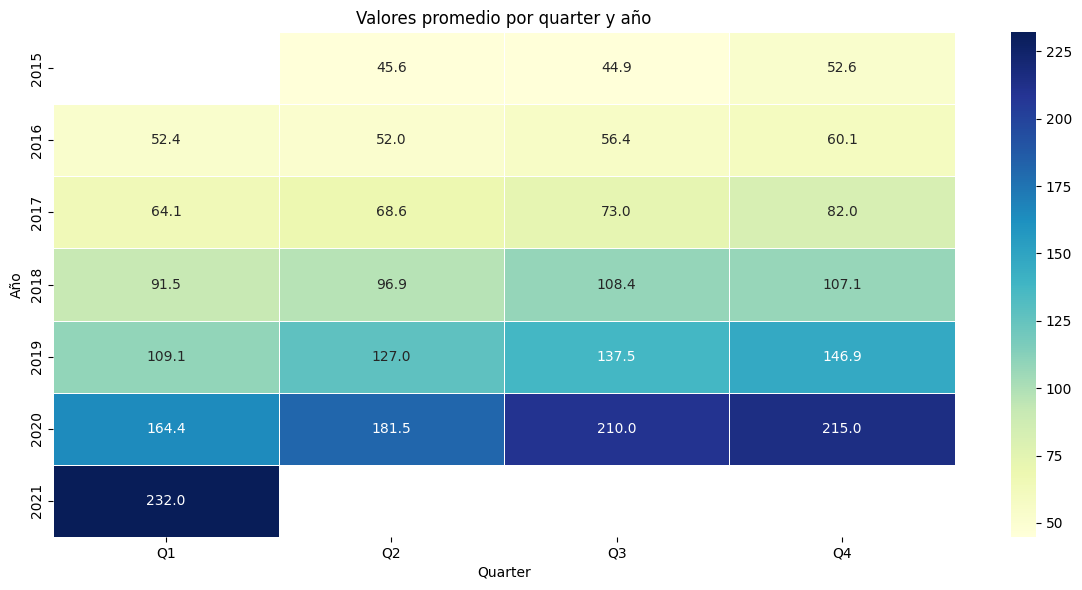

In [12]:
quarter_avg = df.groupby(['Year', 'Quarter'])['Close'].mean().reset_index()
heatmap_quarter = quarter_avg.pivot(index='Year', columns='Quarter', values='Close')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_quarter, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5,
            xticklabels=['Q1', 'Q2', 'Q3', 'Q4'])

plt.title("Valores promedio por quarter y año")
plt.xlabel("Quarter")
plt.ylabel("Año")
plt.tight_layout()
plt.show()

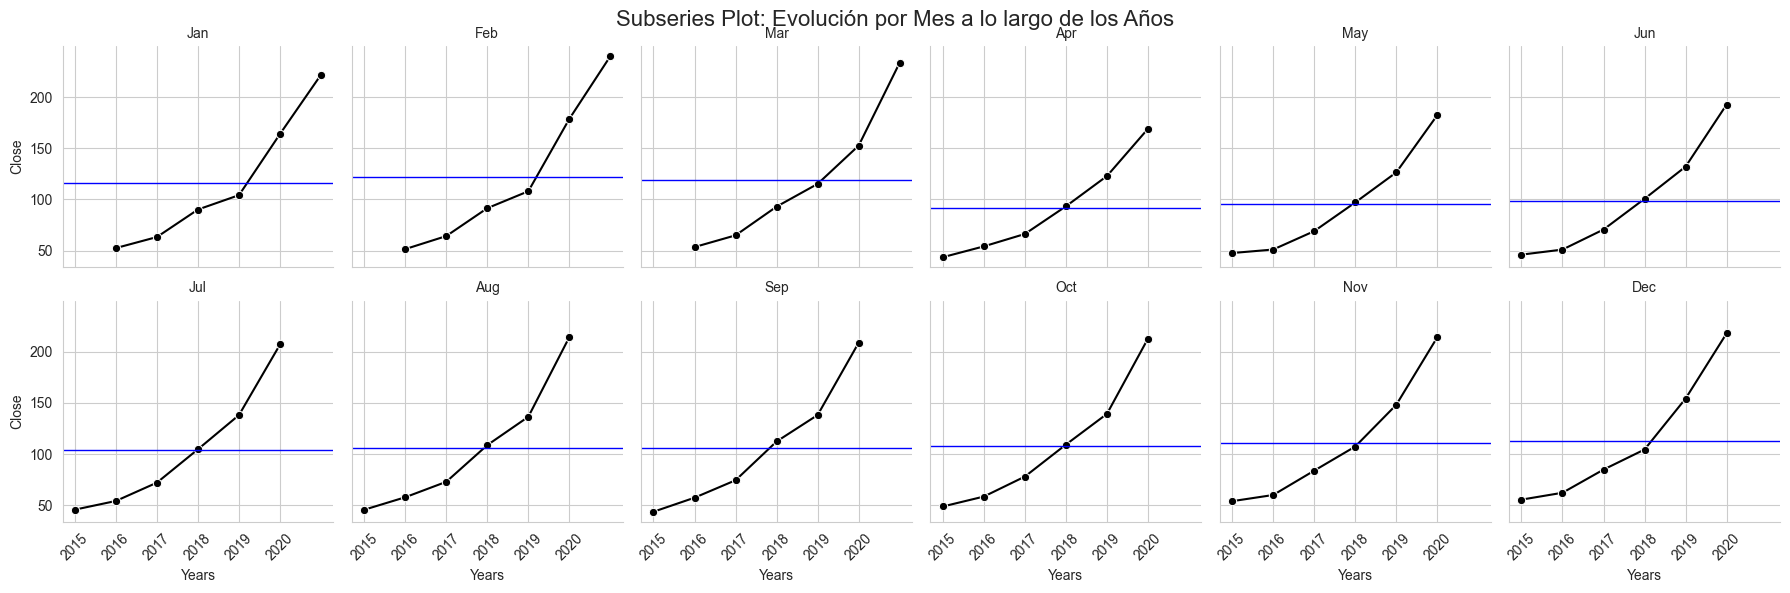

In [ ]:
sns.set_style("whitegrid")
monthly_avg  = df.groupby(['Year', 'Month', 'Month_name'])['Close'].mean().reset_index()
monthly_avg  = monthly_avg.sort_values(by='Month_name')
g = sns.FacetGrid(monthly_avg, col="Month_name", col_wrap=6, col_order=[
    'Jan','Feb','Mar','Apr','May','Jun',
    'Jul','Aug','Sep','Oct','Nov','Dec'
])

# Dibujar la línea negra
g.map_dataframe(sns.lineplot, x='Year', y='Close', color='black', marker='o')

# Añadir línea horizontal azul
def add_mean_line(data, **kwargs):
    plt.axhline(data['Close'].mean(), color='blue', linestyle='-', linewidth=1)

g.map_dataframe(add_mean_line)

# Función para configurar los años en el eje X
def set_year_ticks(data, **kwargs):
    ax = plt.gca()
    years = sorted(data['Year'].unique())
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)

g.map_dataframe(set_year_ticks)

# Ajustes finales
g.set_titles(col_template="{col_name}")
g.set_xlabels('Years')
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Subseries Plot: Evolución por Mes a lo largo de los Años", fontsize=16)
plt.show()

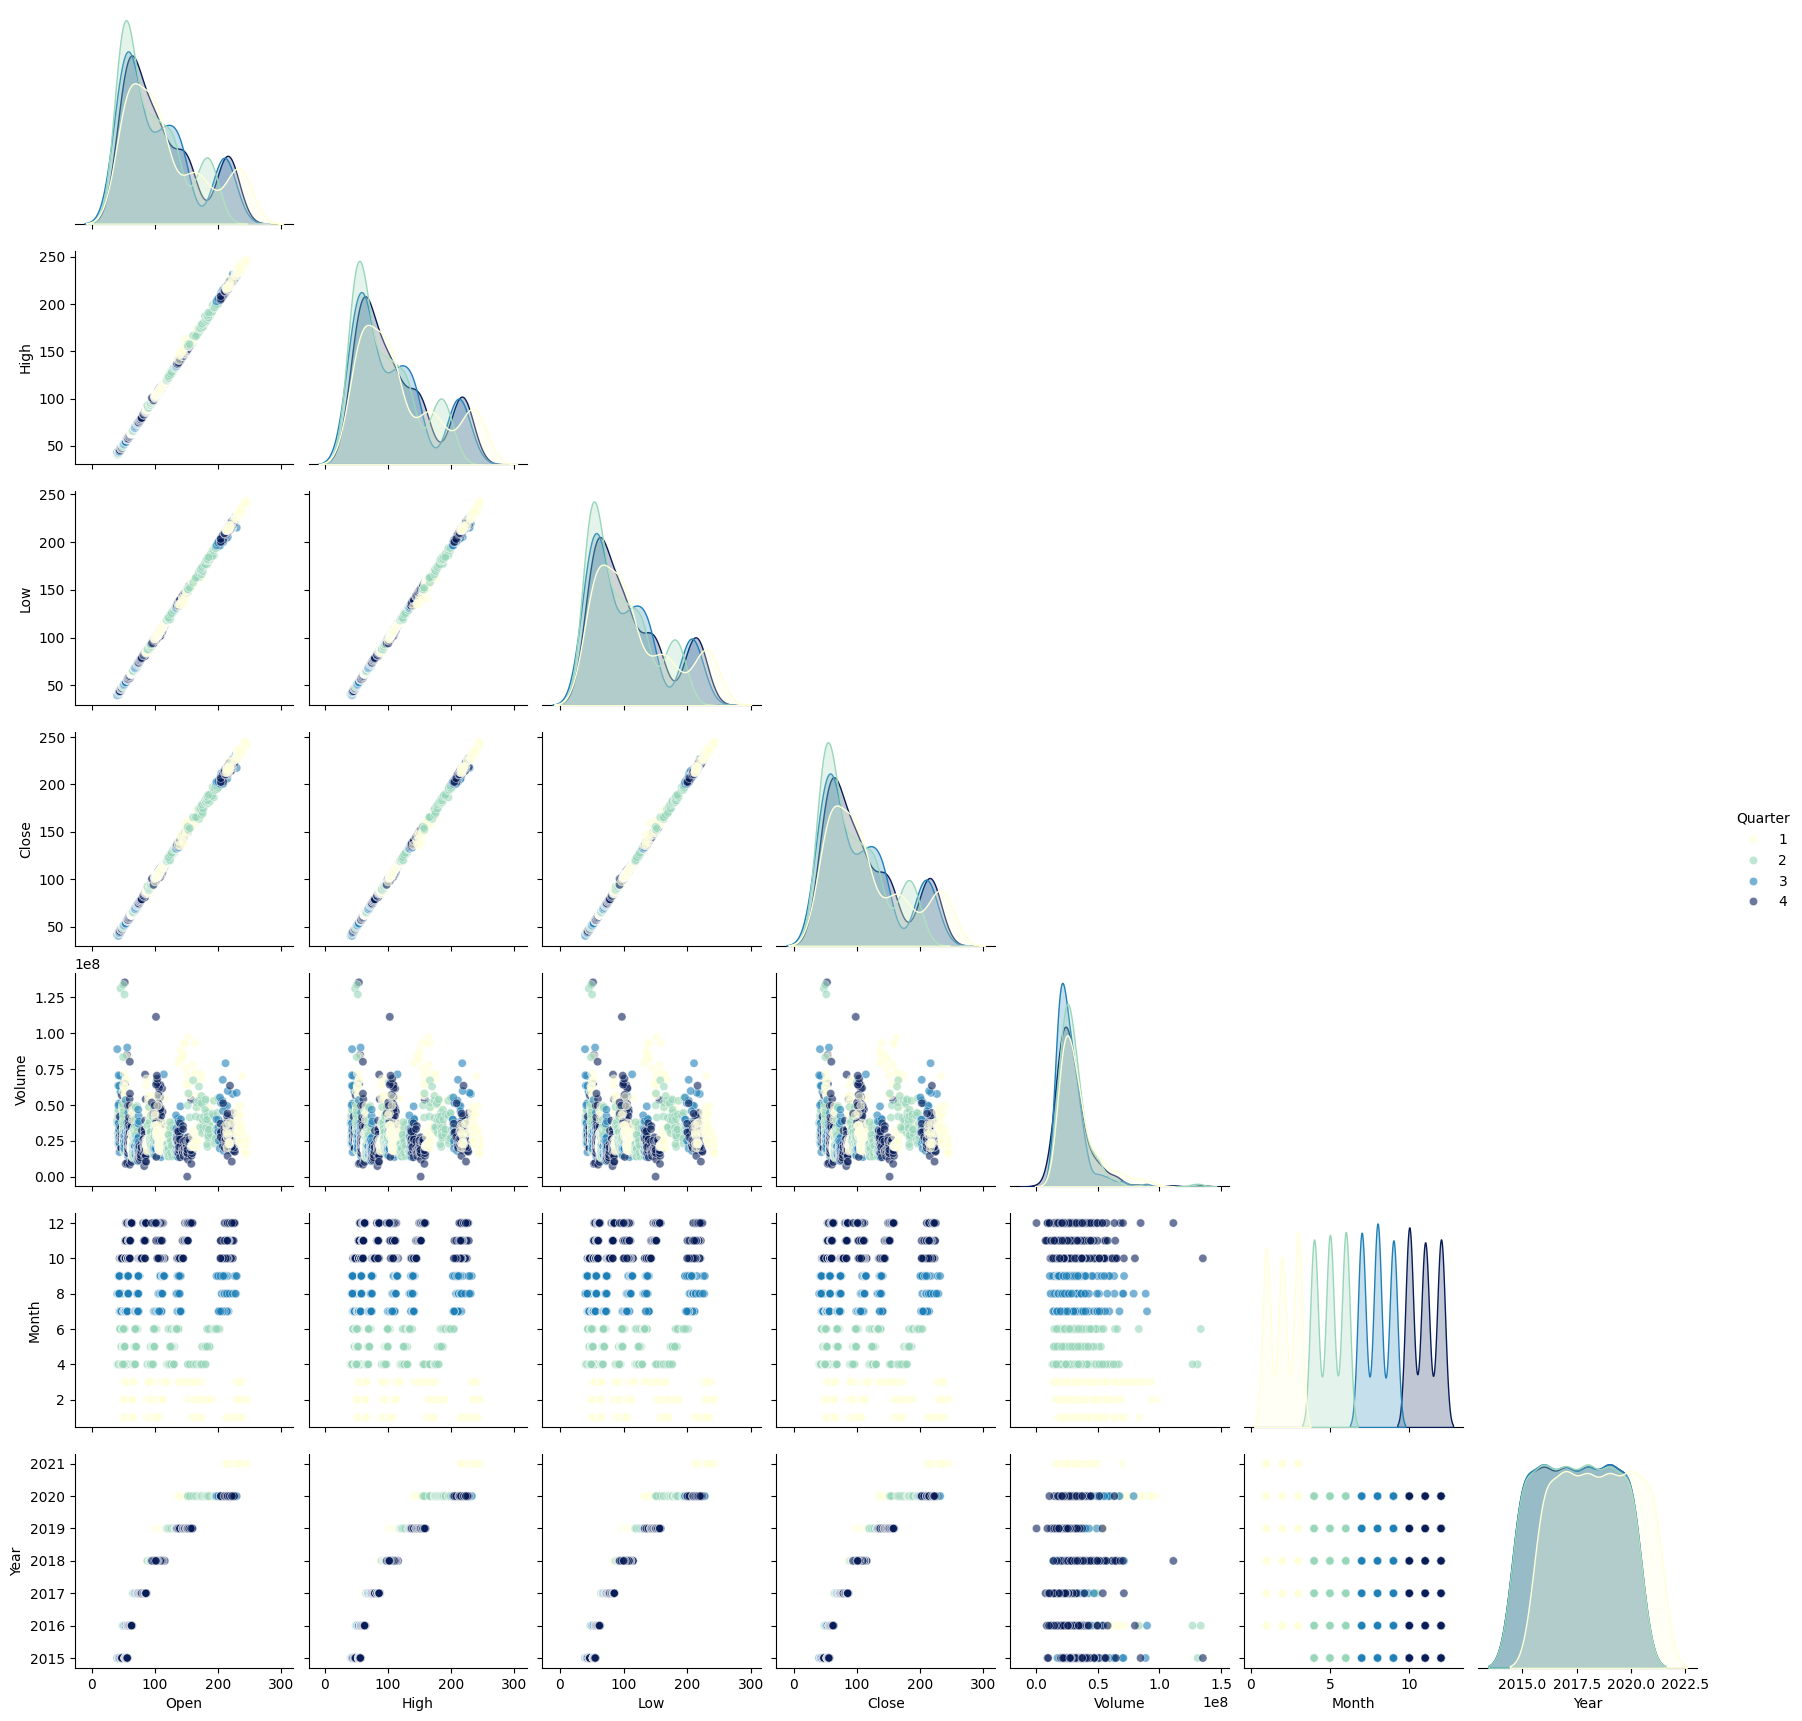

In [15]:
sns.pairplot(df, 
             hue='Quarter',         
             diag_kind='kde',     
             corner=True,         
             plot_kws={'alpha': 0.6},
             palette="YlGnBu")

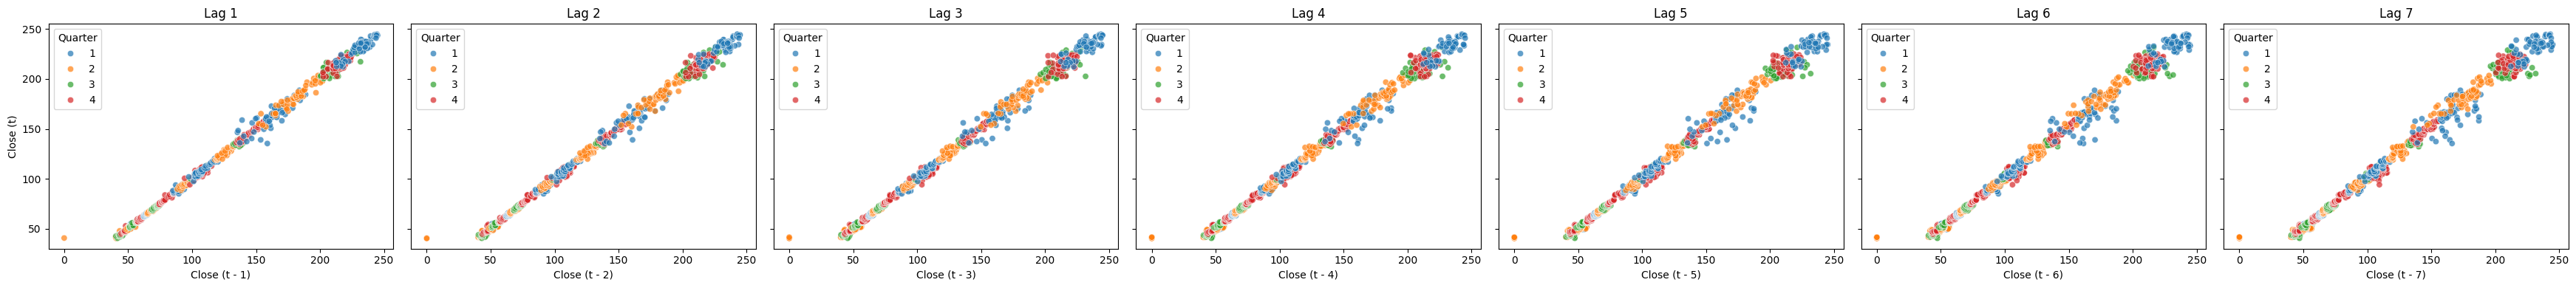

In [23]:
def lag_plots(df, value_col, period_col, k):
    """
    Crea k gráficos de dispersión con los retrasos (lags) de una variable.
    
    Parámetros:
    - df: DataFrame con columna temporal
    - value_col: nombre de la columna a usar (ej. 'Close')
    - period_col: columna con el periodo estacional (ej. 'month', 'quarter')
    - k: número de retrasos (lags)
    """
    
    # Copiar para no modificar el df original
    df = df.copy()

    # Crear lags
    for i in range(1, k + 1):
        df[f'{value_col}_lag_{i}'] = df[value_col].shift(i)
    
    # Eliminar filas con NaNs generados por los lags
    df_clean = df.fillna(0)
    
    # Crear subplots
    fig, axes = plt.subplots(nrows=1, ncols=k, figsize=(5 * k, 4), sharey=True)
    if k == 1:
        axes = [axes]  # Para que funcione también con k = 1

    for i, ax in enumerate(axes, 1):
        sns.scatterplot(
            data=df_clean,
            x=f'{value_col}_lag_{i}',
            y=value_col,
            hue=period_col,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )
        ax.set_title(f"Lag {i}")
        ax.set_xlabel(f"{value_col} (t - {i})")
        ax.set_ylabel(f"{value_col} (t)")

    plt.tight_layout()
    plt.show()
lag_plots(df, 'Close', 'Quarter', 7)

Mucho mayor incremento en el Q4 que en los demás

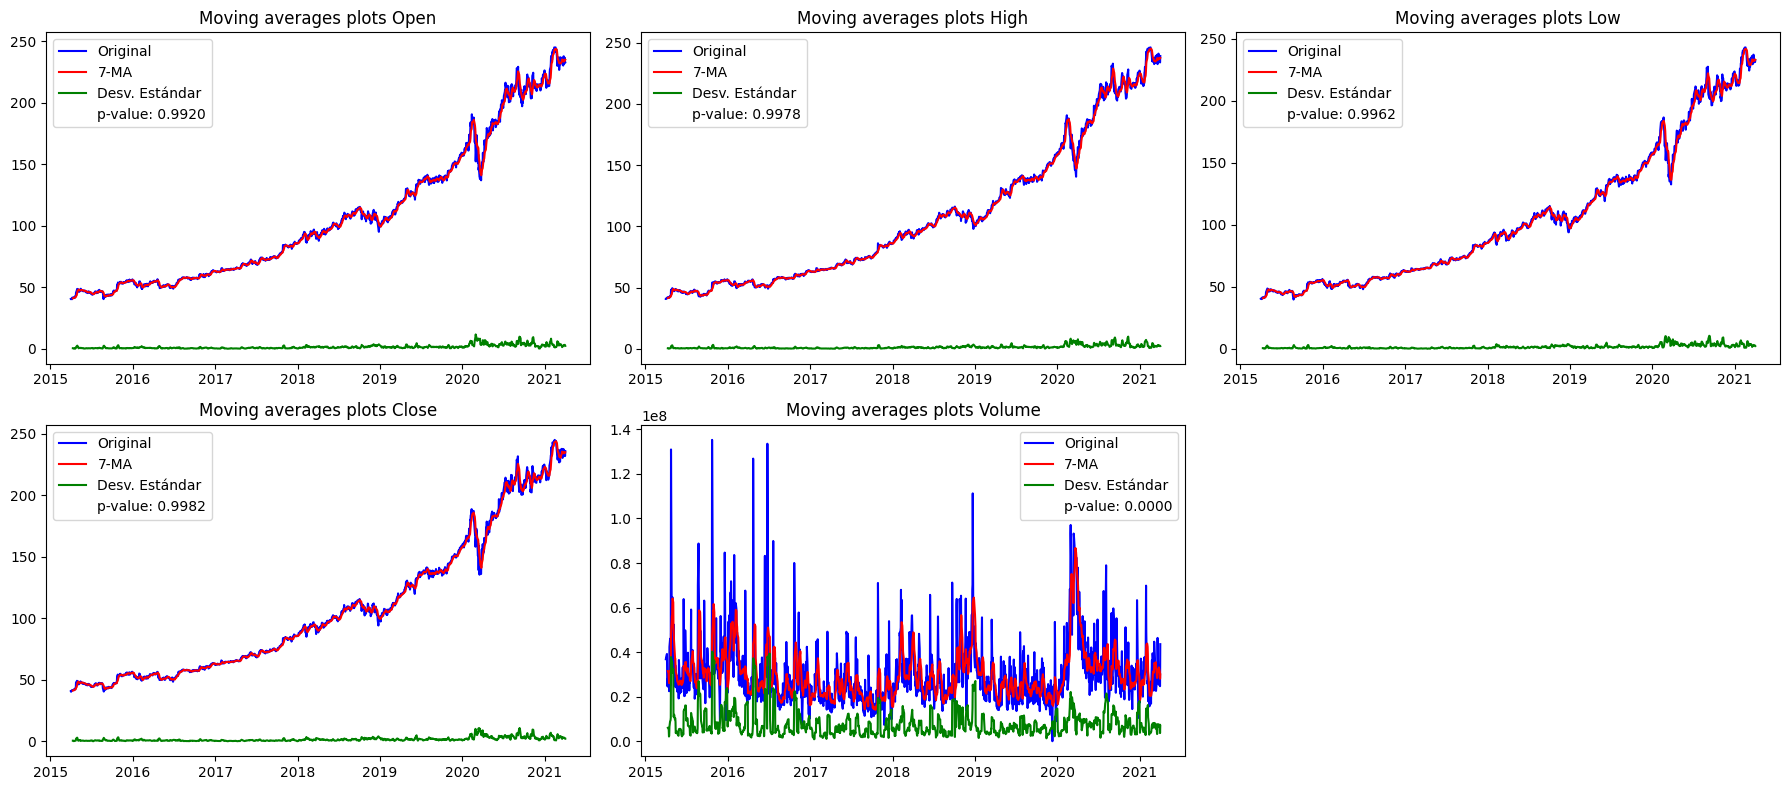

In [7]:
def moving_average(series, window_, col, ax):
    mov_avg = series.rolling(window=window_).mean()
    mov_std = series.rolling(window=window_).std()

    # ADF Test
    df_test = adfuller(series.dropna(), autolag='AIC')
    p_value = df_test[1]
    df_out = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    if p_value <= 0.05:
        estacionaria = True
    else:
        estacionaria = False

    # Plot
    ax.set_title(f'Moving averages plots {col}')
    ax.plot(series.index, series, color='blue', label='Original')
    ax.plot(series.index, mov_avg, color='red', label=f'{window_}-MA')
    ax.plot(series.index, mov_std, color='green', label='Desv. Estándar')
    ax.plot([], [], ' ', label=f'p-value: {p_value:.4f}')  # Línea vacía para leyenda

    ax.legend()
    
    return estacionaria

WINDOW = 7
cols = [col for col in df.columns if col != 'Date']
n = len(cols)

plots_per_row = 3  # Cambia a 2 si quieres dos por fila
rows = int(np.ceil(n / plots_per_row))

fig, axs = plt.subplots(rows, plots_per_row, figsize=(6 * plots_per_row, 4 * rows))
axs = np.atleast_2d(axs)

no_estacionarias = []

for i, col in enumerate(cols):
    r = i // plots_per_row
    c = i % plots_per_row
    es_estacionaria = moving_average(df[col], WINDOW, col, ax=axs[r, c])
    if not es_estacionaria:
        no_estacionarias.append(col)

# Elimina ejes vacíos
for j in range(n, rows * plots_per_row):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()


# Diferenciación de la serie

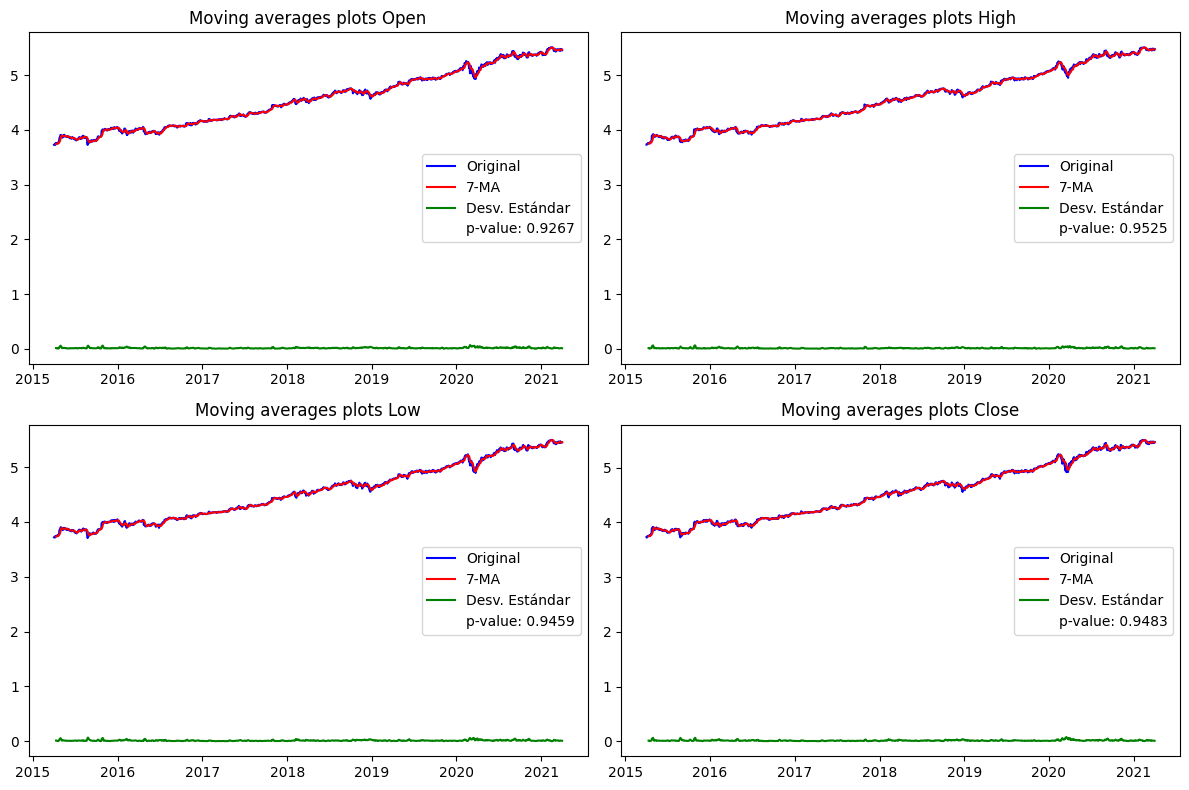

In [8]:
df_log = df.copy()
WINDOW = 7
cols = [col for col in no_estacionarias]
n = len(cols)

plots_per_row = 2  
rows = int(np.ceil(n / plots_per_row))

fig, axs = plt.subplots(rows, plots_per_row, figsize=(6 * plots_per_row, 4 * rows))
axs = np.atleast_2d(axs)

no_estacionarias = []

for i, col in enumerate(cols):
    r = i // plots_per_row
    c = i % plots_per_row
    df_log[col] = np.log1p(df_log[col])
    es_estacionaria = moving_average(df_log[col], WINDOW, col, ax=axs[r, c])
    if not es_estacionaria:
        no_estacionarias.append(col)

# Elimina ejes vacíos
for j in range(n, rows * plots_per_row):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()
    

df_log = df_log.fillna(0)

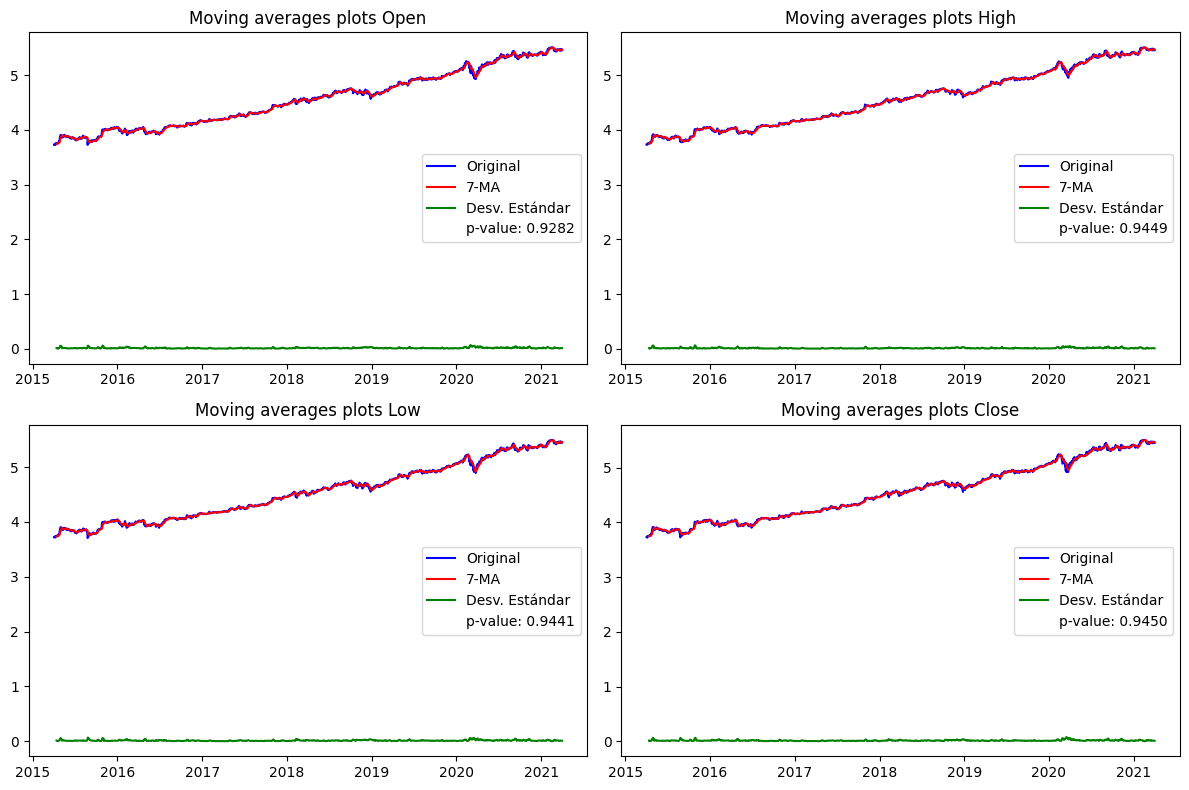

In [9]:
df_diffed_once = df_log.copy()
WINDOW = 7
cols = [col for col in no_estacionarias]
n = len(cols)

plots_per_row = 2  
rows = int(np.ceil(n / plots_per_row))

fig, axs = plt.subplots(rows, plots_per_row, figsize=(6 * plots_per_row, 4 * rows))
axs = np.atleast_2d(axs)

no_estacionarias = []

for i, col in enumerate(cols):
    r = i // plots_per_row
    c = i % plots_per_row
    df_diffed_once[col] = df_diffed_once[col].shift(1)
    es_estacionaria = moving_average(df_diffed_once[col], WINDOW, col, ax=axs[r, c])
    if not es_estacionaria:
        no_estacionarias.append(col)

# Elimina ejes vacíos
for j in range(n, rows * plots_per_row):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()
    

df_diffed_once = df_diffed_once.fillna(0)

# Componentes autoregressivos y residuos

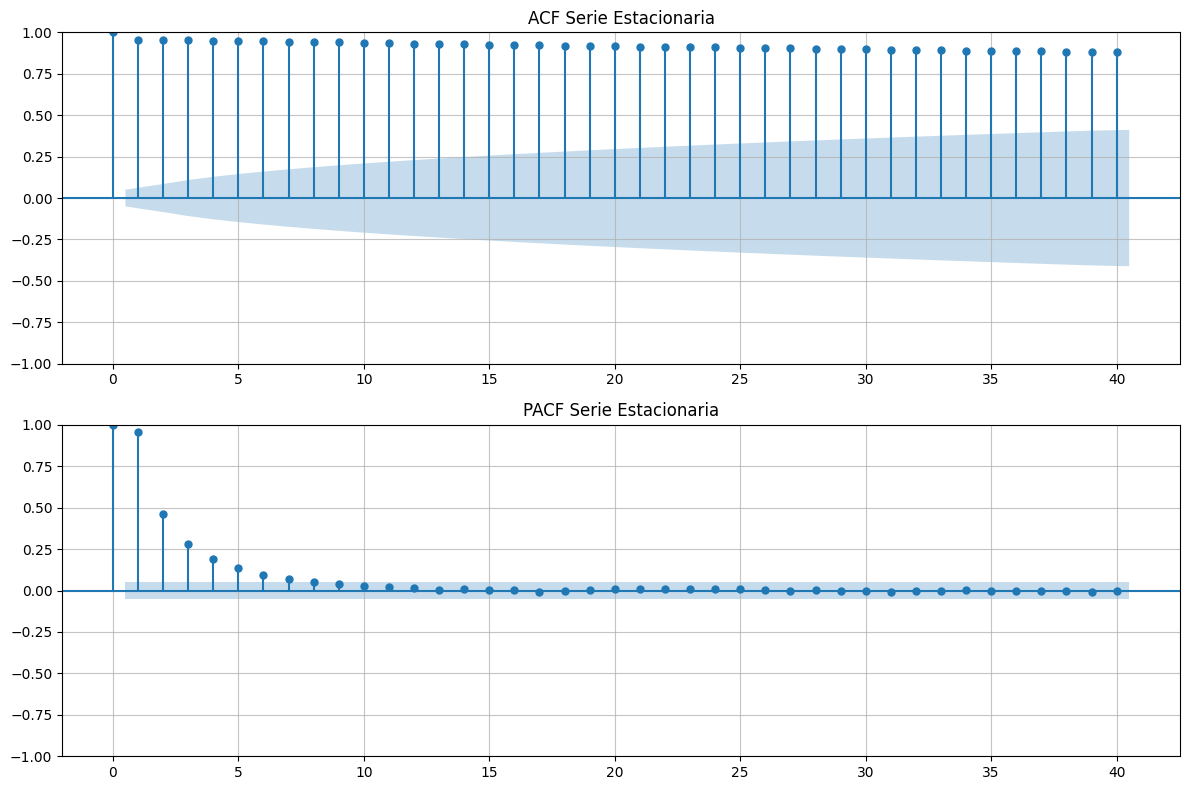

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plot_acf(df_diffed_once['Close'].dropna(), lags=40, title="ACF Serie Estacionaria", ax=plt.gca())
plt.grid(alpha=0.75)

plt.subplot(212)
plot_pacf(df_diffed_once['Close'].dropna(), lags=40, title="PACF Serie Estacionaria", method='ywm', ax=plt.gca())
plt.grid(alpha=0.75)

plt.tight_layout()
plt.show()


 Esto ocurre debido a la tendencia de la serie y que en precios de bolsa el valor de ayer define en gran parte el valor de hoy

In [ ]:
df_diff_twice.fillna(0, inplace = True)

df_filtro_2020 = df_diff_twice['Date'] >= '2020-01-01'
data_modelo_viejo = df_diff_twice.loc[~df_filtro_2020]
data_model1 = df_diff_twice.loc[df_filtro_2020]

data_model1.head()


In [ ]:
moving_average(data_model1['Close'], 7)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plot_acf(data_model1['Close'].dropna(), lags=40, title="ACF Serie Estacionaria", ax=plt.gca())
plt.grid(alpha=0.75)

plt.subplot(212)
plot_pacf(data_model1['Close'].dropna(), lags=40, title="PACF Serie Estacionaria", method='ywm', ax=plt.gca())
plt.grid(alpha=0.75)

plt.tight_layout()
plt.show()


# Serie de Fourier

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier_week = CalendarFourier('W', order = 2)
fourier_month = CalendarFourier('M', order=8)

X = DeterministicProcess(
    index = data_model1.index,
    constant=True,
    seasonal=False,
    order = 1,
    additional_terms=[fourier_week, fourier_month],
    drop=True
)
X_features = X.in_sample()



In [ ]:
data_model1['Volume'] = data_model1['Volume'].shift(1)
moving_average(data_model1['Volume'], 7)

In [ ]:
data_model1.head()

In [ ]:
# Lags Features

def make_lags(series, col, lags):
    return pd.concat(
        {
            f'{col}_lag_{i}': series.shift(i) for i in range(1, lags + 1)
        },
        axis=1)
lags = make_lags(data_model1['Close'], 'y', lags = 10).fillna(0)
lags_vol = make_lags(data_model1['Volumen'], 'Volumne', lags=5)
